In [14]:
%matplotlib inline
from biocrnpyler import *

import numpy as np
import pylab as plt
from matplotlib.pyplot import figure

from biocrnpyler.chemical_reaction_network import Species, Reaction, ChemicalReactionNetwork

Chemical reaction network for the violacein pathway.

$$\text{Tryptophan (TRP)} \leftrightarrow^{VioA} \text{IPA imine}$$
$$\text{2 IPA imine} \leftrightarrow^{VioB} \text{IPA imine dimer}$$
$$\text{IPA imine dimer} \leftrightarrow^{VioE} \text{Protodeoxyviolaceinic acid (PTDVA)}$$
$$\text{Protodeoxyviolaceinic acid (PTDVA)} \leftrightarrow^{VioD} \text{Protoviolaceinic acid (PTVA)}$$
$$\text{Protoviolaceinic acid (PTVA)} \leftrightarrow^{VioC} \text{Violacein (V)}\text{        (This is the desired end-product)}$$
$$\text{Protodeoxyviolaceinic acid (PTDVA)} \leftrightarrow^{VioC} \text{Deoxyviolacein (DV)}\text{        (This is a side-reaction)}$$




In [15]:
#DNA species
d_vioA = Species("vioA", material_type = "dna")
d_vioB = Species("vioB", material_type = "dna")
d_vioE = Species("vioE", material_type = "dna")
d_vioD = Species("vioD", material_type = "dna")
d_vioC = Species("vioC", material_type = "dna")

#Transcript species
t_vioA = Species("vioA", material_type = "transcript") 
t_vioB = Species("vioB", material_type = "transcript") 
t_vioE = Species("vioE", material_type = "transcript") 
t_vioD = Species("vioD", material_type = "transcript") 
t_vioC = Species("vioC", material_type = "transcript") 

#Enzyme species
VioA = Species("VioA", material_type = "enzyme")
VioB = Species("VioB", material_type = "enzyme")
VioE = Species("VioE", material_type = "enzyme")
VioD = Species("VioD", material_type = "enzyme")
VioC = Species("VioC", material_type = "enzyme")

#Pathway organic molecule species
TRP = Species("TRP", material_type = "organic_molecule")
IPA_imine = Species("IPA_imine", material_type = "organic_molecule")
IPA_imine_dimer = Species("IPA_imine_dimer", material_type = "organic_molecule")
PTDVA = Species("PTDVA", material_type = "organic_molecule")
PTVA = Species("PTVA", material_type = "organic_molecule")
DV = Species("DV", material_type = "organic_molecule")
V = Species("V", material_type = "organic_molecule")

#DNA assembly
G1_VioA = DNAassembly(str(d_vioA), promoter = "P", rbs = "RBS", transcript = t_vioA, protein = VioA)
G2_VioB = DNAassembly(str(d_vioB) , promoter = "P", rbs = "RBS", transcript = t_vioB, protein = VioB)
G3_VioE = DNAassembly(str(d_vioE) , promoter = "P", rbs = "RBS", transcript = t_vioE, protein = VioE)
G4_VioD = DNAassembly(str(d_vioD) , promoter = "P", rbs = "RBS", transcript = t_vioD, protein = VioD)
G5_VioC = DNAassembly(str(d_vioC) , promoter = "P", rbs = "RBS", transcript = t_vioC, protein = VioC)


VioB_kb = 10
VioB_ku = 1
VioB_kcat = 450
michalis_parameters = {("michalis_menten", "VioA", "kb"):10, ("michalis_menten", "VioA", "ku"):1, ("michalis_menten", "VioA", "kcat"):203,
                       ("michalis_menten", "VioB", "kb"):VioB_kb, ("michalis_menten", "VioB", "ku"):VioB_ku, ("michalis_menten", "VioB", "kcat"):VioB_kcat*VioB_kb/VioB_ku}    

mech_michalis = MichalisMenten()
specific_mechanisms = {mech_michalis.mechanism_type:mech_michalis}




#Enzyme assembly
E1_VioA = Enzyme(enzyme = VioA, substrate = "TRP", product = "IPA_imine", mechanisms = specific_mechanisms, parameters = michalis_parameters)
E2_VioB = MultiEnzyme(enzyme = VioB, substrates = ["IPA_imine", "IPA_imine"], products = ["IPA_imine_dimer"], mechanisms = specific_mechanisms, parameters = michalis_parameters)
E3_VioE = Enzyme(enzyme = VioE, substrate = "IPA_imine_dimer", product = "PTDVA")
E4_VioD = Enzyme(enzyme = VioD, substrate = "PTDVA", product = "PTVA")
E5_VioC = Enzyme(enzyme = VioC, substrate = "PTVA", product = "V")
E5_VioC_side = Enzyme(enzyme = VioC, substrate ="PTDVA", product = "DV")

#create a transcription and translation Mechanisms. 
mech_tx = SimpleTranscription()
mech_tl = SimpleTranslation()

#Enzyme mechanisms
mech_cat = BasicCatalysis()

#Mechanisms dictionary
default_mechanisms = {mech_tx.mechanism_type:mech_tx, mech_tl.mechanism_type:mech_tl, mech_cat.mechanism_type:mech_cat}

#Parameters
default_parameters = {"kb":100, "ku":10, "ktx":.5, "ktl":2, "kcat":100}



M1 = TxTlExtract("e coli extract", components = [G1_VioA, G2_VioB, G3_VioE, G4_VioD, G5_VioC, E1_VioA, E2_VioB, E3_VioE, E4_VioD, E5_VioC, E5_VioC_side], parameters = default_parameters ,parameter_file = "default_parameters.txt")
CRN1 = M1.compile_crn()
#print(repr(M1),"\n", CRN1.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")


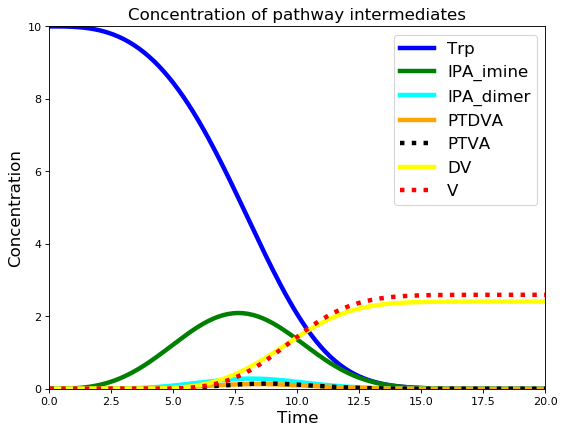

In [22]:
# Define initial conditions for Rheostat + ATP Leak
timepoints = np.linspace(0, 100, 1000)

trp = 10
dna_conc = 10
x0 = {"TRP":trp, "dna_dna_vioA":dna_conc, "dna_dna_vioB":dna_conc, "dna_dna_vioE":dna_conc, "dna_dna_vioD":dna_conc, "dna_dna_vioC":dna_conc}


      
      
R1 = CRN1.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(timepoints, R1["TRP"], color = 'blue', lw = 4, label = 'Trp')
plt.plot(timepoints, R1["IPA_imine"], color = 'green', lw = 4, label = 'IPA_imine')
plt.plot(timepoints, R1["IPA_imine_dimer"], color = 'cyan', lw = 4, label = 'IPA_dimer')
plt.plot(timepoints, R1["PTDVA"], color = 'orange', lw = 4, label = 'PTDVA')
plt.plot(timepoints, R1["PTVA"], ":", color = 'black', lw = 4, label = 'PTVA')


plt.plot(timepoints, R1["DV"], color = 'yellow', lw = 4, label = 'DV')
plt.plot(timepoints, R1["V"], ":" , color = "red" , lw = 4, label = 'V')
plt.legend(fontsize = 15)


plt.xlim(0, 20)
plt.ylim(0, 10)
plt.title('Concentration of pathway intermediates', size = "15")
plt.xlabel("Time", fontsize = "15")
plt.ylabel("Concentration", fontsize = "15");
plt.show()

In [19]:

M2 = TxTlExtract("e coli extract", components = [G1_VioA, G2_VioB, G3_VioE, G4_VioD, G5_VioC, E1_VioA, E2_VioB, E3_VioE, E4_VioD, E5_VioC], parameters = default_parameters ,parameter_file = "default_parameters.txt")
CRN2 = M2.compile_crn()
#print(repr(M2),"\n", CRN2.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")

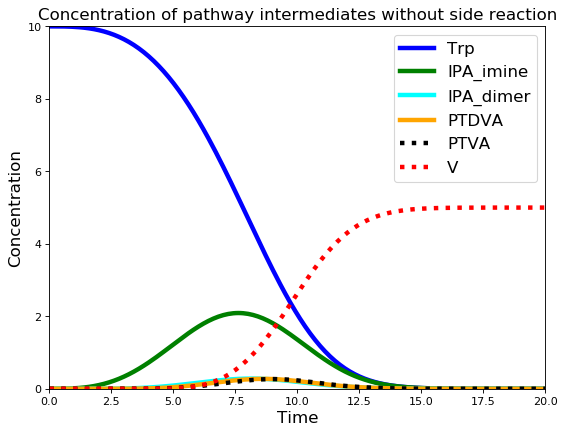

In [23]:
# Define initial conditions for Rheostat + ATP Leak
timepoints = np.linspace(0, 100, 1000)

trp = 10
dna_conc = 10
x0 = {"TRP":trp, "dna_dna_vioA":dna_conc, "dna_dna_vioB":dna_conc, "dna_dna_vioE":dna_conc, "dna_dna_vioD":dna_conc, "dna_dna_vioC":dna_conc}

      
R2 = CRN2.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(timepoints, R2["TRP"], color = 'blue', lw = 4, label = 'Trp')
plt.plot(timepoints, R2["IPA_imine"], color = 'green', lw = 4, label = 'IPA_imine')
plt.plot(timepoints, R2["IPA_imine_dimer"], color = 'cyan', lw = 4, label = 'IPA_dimer')
plt.plot(timepoints, R2["PTDVA"], color = 'orange', lw = 4, label = 'PTDVA')
plt.plot(timepoints, R2["PTVA"], ":", color = 'black', lw = 4, label = 'PTVA')


#plt.plot(timepoints, "DV", color = 'yellow', lw = 4, label = 'DV')
plt.plot(timepoints, R2["V"], ":" , color = "red" , lw = 4, label = 'V')
plt.legend(fontsize = 15)


plt.xlim(0, 20)
plt.ylim(0, 10)
plt.title('Concentration of pathway intermediates without side reaction', size = "15")
plt.xlabel("Time", fontsize = "15")
plt.ylabel("Concentration", fontsize = "15");
plt.show()